# 🌀 Diffusion Models - Part 1: Diffusing and Denoising MNIST

---

Name: Shahreyar Ashraf
Roll number: 26100342

# 🧪 Task 1: Implementing and Training a Diffusion Model on MNIST


### 🔧 Step 1: Install Required Libraries

Make sure the following libraries are installed: `torch`, `torchvision`, `matplotlib`, and `tqdm`.

Use the cell below to install them.

In [1]:
# Install any needed libraries
!pip install torch torchvision matplotlib tqdm --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.0 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcugraph-cu12 24.12.0 requires pylibraft-cu12==24.12.*, but you have pylibraft-cu12 25.2.0 which is incompatible.
pylibcugraph-cu12 24.12.0 requires rmm-cu12==24.12.*, but you have 

In [1]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import math
from dataclasses import dataclass



## 📥 Load the MNIST Dataset


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
])

mnist = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(mnist, batch_size=64, shuffle=True)
device   = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 480kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.49MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### 🌫️ Step 2: Define the Noise Schedule

Implement your own beta noise schedule for a total of x number of timesteps. x is your own choice.

🧠 **Your task:**
- Decide whether to use a **linear** beta schedule or a **cosine** schedule.
- Implement the schedule accordingly.
- Compute `alphas` and `alpha_hats` for the diffusion process.

> This is your design choice. Think about how each schedule might impact the training.


In [3]:
def make_noise_schedule(
        T:int = 1000,
        schedule:str = "cosine",
        beta_start:float = 1e-4,
        beta_end:float   = 2e-2,
        device:torch.device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
    ):
    if schedule == "linear":
        betas = torch.linspace(beta_start, beta_end, T, dtype=torch.float32, device=device)

    elif schedule == "cosine":
        s = 0.008
        steps = torch.arange(T + 1, dtype=torch.float32, device=device)
        alpha_bar = torch.cos(((steps / T + s) / (1 + s)) * torch.pi * 0.5) ** 2
        betas = 1 - alpha_bar[1:] / alpha_bar[:-1]
        betas = betas.clamp(max=0.999)

    alphas     = 1.0 - betas
    alpha_hats = torch.cumprod(alphas, dim=0)
    return betas, alphas, alpha_hats

### 💨 Step 3: Implement Forward Diffusion Function

Create a function `forward_diffusion_sample(x_0, t)` that:

- Adds noise to the input image `x_0` at a given timestep `t`.
- Returns both the noised image and the added noise.

Use your computed `alpha_hats` to scale the input and noise correctly.


In [4]:
def forward_diffusion_sample(x_0, t, *, noise=None):
    if noise is None:
        noise = torch.randn_like(x_0)

    if not torch.is_tensor(t):
        t = torch.tensor([t], device=x_0.device)
    t = t.view(-1)
    if t.numel() == 1 and x_0.size(0) > 1:
        t = t.expand(x_0.size(0))
    coef1 = sqrt_alpha_hats[t].view(-1, 1, 1, 1)
    coef2 = sqrt_one_minus_ahats[t].view(-1, 1, 1, 1)

    x_t = coef1 * x_0 + coef2 * noise
    return x_t, noise

### 👁️ Step 4: Visualize the Diffusion Process

Pick a sample image from the dataset and visualize how it looks after applying noise at different timesteps (e.g. t = 0, 50, 100, 150, 199, ... x)



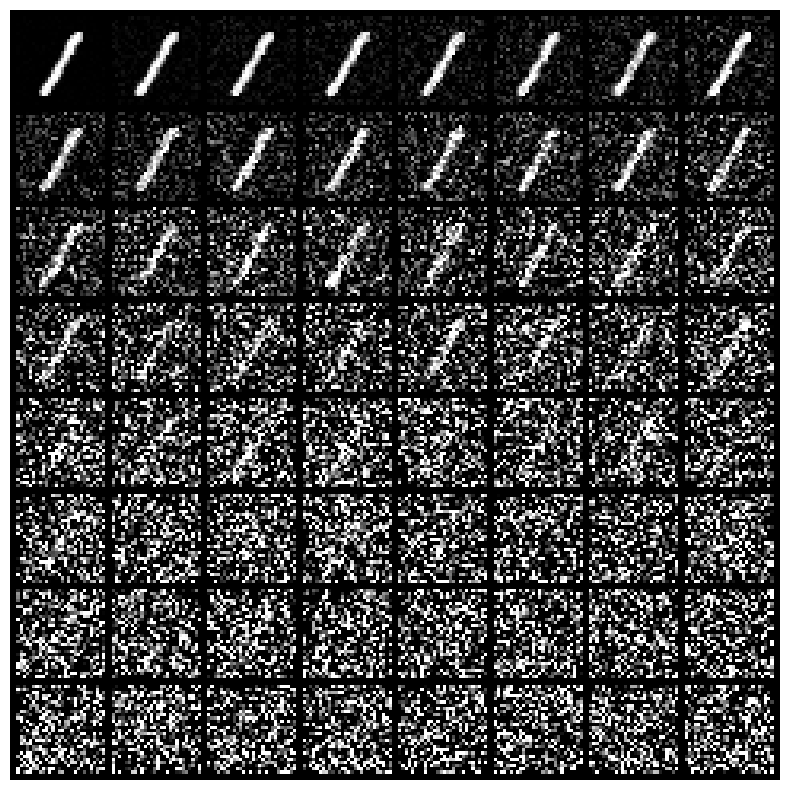

In [5]:
def show_image_grid(images):
    grid = make_grid(images, nrow=8)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.show()

x, _ = next(iter(dataloader))
x = x[:1].to(device)
T = 1000
num_show = 64
timesteps = torch.linspace(0, T-1, num_show, dtype=torch.long)

betas, alphas, alpha_hats = make_noise_schedule(
        T=T, schedule="cosine", device=device)

sqrt_alpha_hats      = torch.sqrt(alpha_hats)
sqrt_one_minus_ahats = torch.sqrt(1.0 - alpha_hats)

noised_images = []
for t in timesteps:
    t_batch = torch.tensor([t])
    noised, _ = forward_diffusion_sample(x, t_batch)
    noised_images.append(noised)

show_image_grid(torch.cat(noised_images, dim=0))


### 🧠 Step 5: Build the Denoising Model

Implement a U-Net style architecture to predict noise given a noisy image and a timestep `t`.


In [6]:
class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        device = t.device
        half = self.dim // 2
        emb = math.log(10000) / (half - 1)
        emb = torch.exp(torch.arange(half, device=device) * -emb)
        emb = t.float().unsqueeze(1) * emb.unsqueeze(0)
        emb = torch.cat([emb.sin(), emb.cos()], dim=-1)
        return emb 

class AttentionBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.norm = nn.GroupNorm(8, channels)
        self.qkv  = nn.Conv2d(channels, channels * 3, 1)
        self.proj = nn.Conv2d(channels, channels, 1)
        self.scale = channels ** -0.5

    def forward(self, x):
        B, C, H, W = x.shape
        h = self.norm(x)
        qkv = self.qkv(h).reshape(B, 3, C, H * W)
        q, k, v = qkv[:,0], qkv[:,1], qkv[:,2]
        attn = torch.softmax((q * self.scale) @ k.transpose(-2,-1), dim=-1)
        y = (attn @ v).reshape(B, C, H, W)
        return x + self.proj(y)

class ResBlock(nn.Module):
    def __init__(self, in_c, out_c, time_dim, dropout=0.1):
        super().__init__()
        self.norm1 = nn.GroupNorm(8, in_c)
        self.conv1 = nn.Conv2d(in_c, out_c, 3, padding=1)
        self.norm2 = nn.GroupNorm(8, out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, 3, padding=1)
        self.time_mlp = nn.Linear(time_dim, out_c * 2)
        self.dropout = nn.Dropout(dropout)
        self.skip = nn.Conv2d(in_c, out_c, 1) if in_c != out_c else nn.Identity()

    def forward(self, x, t_emb):
        h = self.norm1(x)
        h = F.silu(h)
        h = self.conv1(h)
        scale_shift = self.time_mlp(t_emb).unsqueeze(-1).unsqueeze(-1)
        scale, shift = scale_shift.chunk(2, dim=1)
        h = h * (1 + scale) + shift
        h = self.norm2(h)
        h = F.silu(h)
        h = self.dropout(self.conv2(h))
        return h + self.skip(x)

class Down(nn.Module):
    def __init__(self, in_c, out_c, time_dim):
        super().__init__()
        self.res1 = ResBlock(in_c, out_c, time_dim)
        self.res2 = ResBlock(out_c, out_c, time_dim)
        self.pool = nn.Conv2d(out_c, out_c, 4, stride=2, padding=1)

    def forward(self, x, t_emb):
        x = self.res1(x, t_emb)
        x = self.res2(x, t_emb)
        skip = x
        return self.pool(x), skip

class Up(nn.Module):
    def __init__(self, in_c, skip_c, out_c, time_dim):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv = nn.Conv2d(in_c, out_c, 3, padding=1)
        self.res1 = ResBlock(out_c + skip_c, out_c, time_dim)
        self.res2 = ResBlock(out_c, out_c, time_dim)

    def forward(self, x, skip, t_emb):
        x = self.up(x)
        x = self.conv(x)
        if x.shape[-2:] != skip.shape[-2:]:
            x = F.interpolate(x, size=skip.shape[-2:], mode='nearest')
        x = torch.cat([x, skip], dim=1)
        x = self.res1(x, t_emb)
        x = self.res2(x, t_emb)
        return x

class UNetMNIST(nn.Module):
    def __init__(self, img_ch=1, base_ch=128, time_dim=256):
        super().__init__()
        self.time_embed = SinusoidalTimeEmbedding(time_dim)
        self.conv0 = nn.Conv2d(img_ch, base_ch, 3, padding=1)

        # encoder
        self.down1 = Down(base_ch, base_ch, time_dim)
        self.down2 = Down(base_ch, base_ch * 2, time_dim)
        self.down3 = Down(base_ch * 2, base_ch * 4, time_dim)

        # bottleneck
        self.bot1 = ResBlock(base_ch * 4, base_ch * 4, time_dim)
        self.attn = AttentionBlock(base_ch * 4)
        self.bot2 = ResBlock(base_ch * 4, base_ch * 2, time_dim)

        # decoder
        self.up2 = Up(base_ch * 2, base_ch * 2, base_ch, time_dim)
        self.up1 = Up(base_ch, base_ch, base_ch, time_dim)

        # head
        self.out = nn.Sequential(
            nn.GroupNorm(8, base_ch),
            nn.SiLU(),
            nn.Conv2d(base_ch, img_ch, 3, padding=1)
        )

    def forward(self, x, t):
        t_emb = self.time_embed(t)
        x = self.conv0(x)
        x, s1 = self.down1(x, t_emb)
        x, s2 = self.down2(x, t_emb)
        x, s3 = self.down3(x, t_emb)
        x = self.bot1(x, t_emb)
        x = self.attn(x)
        x = self.bot2(x, t_emb)
        x = self.up2(x, s2, t_emb)
        x = self.up1(x, s1, t_emb)
        return self.out(x)


### 🏋️ Step 6: Train the Denoiser

- Instantiate your model and move it to the correct device (`cuda` if available).
- Define an optimizer (e.g., Adam) and a suitable learning rate.
- Write a training loop for the denoiser.

Show the loss at the end of each epoch.

Plot the loss curve

Epoch 01/15 MSE loss: 0.05720
Epoch 02/15 MSE loss: 0.03315
Epoch 03/15 MSE loss: 0.03033
Epoch 04/15 MSE loss: 0.02915
Epoch 05/15 MSE loss: 0.02836
Epoch 06/15 MSE loss: 0.02763
Epoch 07/15 MSE loss: 0.02746
Epoch 08/15 MSE loss: 0.02688
Epoch 09/15 MSE loss: 0.02693
Epoch 10/15 MSE loss: 0.02691
Epoch 11/15 MSE loss: 0.02660
Epoch 12/15 MSE loss: 0.02623
Epoch 13/15 MSE loss: 0.02635
Epoch 14/15 MSE loss: 0.02618
Epoch 15/15 MSE loss: 0.02612


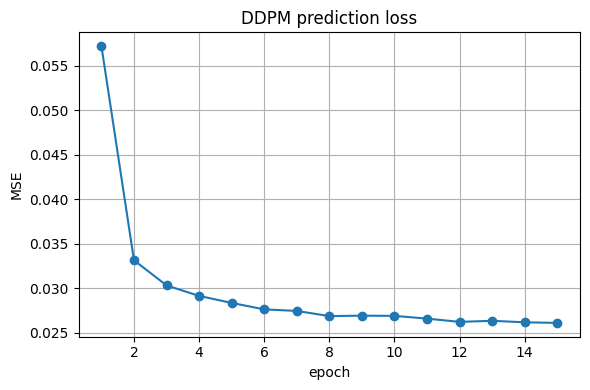

In [10]:
model = UNetMNIST().to(device)
optim      = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)
num_epochs = 15
loss_curve = []

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    for x0, _ in dataloader:
        x0 = x0.to(device)
        t  = torch.randint(0, T, (x0.size(0),), device=device)
        x_t, eps = forward_diffusion_sample(x0, t)
        eps_pred = model(x_t, t)
        loss      = F.mse_loss(eps_pred, eps)

        optim.zero_grad()
        loss.backward()
        optim.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(dataloader)
    loss_curve.append(avg_loss)
    print(f"Epoch {epoch:02d}/{num_epochs} MSE loss: {avg_loss:.5f}")

plt.figure(figsize=(6,4))
plt.plot(range(1, num_epochs + 1), loss_curve, marker='o')
plt.title("DDPM prediction loss")
plt.xlabel("epoch"); plt.ylabel("MSE")
plt.grid(True); plt.tight_layout()
plt.show()

In [ ]:
# torch.save(model.state_dict(), "task1.pt")
# model = UNetMNIST().to(device) 
# state = torch.load("/kaggle/input/task1/pytorch/default/1/task1 (1).pt", map_location=device)
# model.load_state_dict(state)

### ✨ Step 7: Generate a Sample by Reversing Diffusion

Plot the final denoised image.


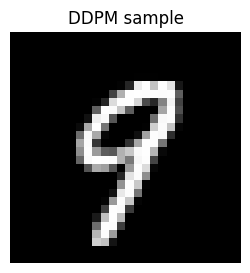

In [12]:
alpha_hats_prev = torch.cat([
    torch.ones(1, device=alpha_hats.device, dtype=alpha_hats.dtype),
    alpha_hats[:-1]
])
posterior_var = betas * (1.0 - alpha_hats_prev) / (1.0 - alpha_hats)
posterior_var = torch.cat([posterior_var, betas[-1:]])

def sample_ddpm(model, img_shape=(1, 28, 28)):
    model.eval()
    B, C, H, W = 1, *img_shape
    x = torch.randn(B, C, H, W, device=device)

    with torch.no_grad():
        for t in reversed(range(T)):
            t_batch = torch.tensor([t], device=device)
            eps_pred = model(x, t_batch)
            coef1 = 1.0 / torch.sqrt(alphas[t])
            coef2 = betas[t] / torch.sqrt(1 - alpha_hats[t])
            mu = coef1 * (x - coef2 * eps_pred)

            if t > 0:
                noise = torch.randn_like(x)
                sigma = torch.sqrt(posterior_var[t])
                x = mu + sigma * noise
            else:
                x = mu
    return x.clamp(0, 1)

final_img = sample_ddpm(model).cpu().squeeze()

plt.figure(figsize=(3,3))
plt.imshow(final_img, cmap="gray")
plt.title("DDPM sample"); plt.axis("off")
plt.show()

## 🧠 Analytical Questions

Answer the following questions in a separate Markdown cell:

1. Prove that the forward process is a Markov chain. What assumptions are being made?
2. Derive the expression for the mean and variance of the noisy image at timestep \( t \).
3. How does the choice of the beta schedule affect the learning process and final image quality?
4. What would happen if we used too few timesteps (e.g., T = 20)?

Forward process as a Markov chain  
By definition, each \(x_t\) is drawn only from \(x_{t-1}\):  
\[
q(x_t\mid x_{0:t-1}) = q(x_t\mid x_{t-1})
  = \mathcal{N}\bigl(x_t;\sqrt{1-\beta_t}\,x_{t-1},\,\beta_tI\bigr).
\]  
Thus \(\{x_t\}\) is Markovian.  


Closed‐form forward diffusion gives  
\[
x_t = \sqrt{\bar\alpha_t}\,x_0 + \sqrt{1-\bar\alpha_t}\,\varepsilon,\quad
\varepsilon\sim\mathcal{N}(0,I),\quad
\bar\alpha_t=\prod_{s=1}^t(1-\beta_s).
\]  
- Mean: \(\mathbb{E}[x_t\mid x_0] = \sqrt{\bar\alpha_t}\,x_0\).  
- Variance: \(\mathrm{Var}[x_t\mid x_0] = (1-\bar\alpha_t)\,I\).

The β-schedule controls per-step noise: higher βₜ adds heavier noise, lower βₜ adds lighter noise.  
Too large βₜ early makes reverse denoising hard; too small βₜ requires many timesteps to reach full noise.  
Smooth schedules yield sharper samples; erratic schedules cause blur and artifacts.  


Too few timesteps 
With only 20 steps, each \(\beta_t\) is large, causing coarse forward jumps.  
Reverse process then faces high discretization error and cannot accurately denoise, yielding blurred or corrupted images.


---
# 🧪 Task 2: Class-Conditional Diffusion on MNIST


### 🧠 Step 1: Define the Conditional Denoising Model

You now need to build a class-conditional version of your denoising U-Net from Task 1.

Requirements:
- Add a learnable **class embedding layer** (`nn.Embedding`) for MNIST digit classes (0–9).
- Concatenate the **time embedding** and **class embedding**.
- Use the combined embedding.




In [15]:
class CondUNetMNIST(UNetMNIST):
    def __init__(self, n_classes: int = 10, **kwargs):
        super().__init__(**kwargs)
        time_dim = kwargs.get("time_dim", 128)
        self.label_emb = nn.Embedding(n_classes, time_dim)

    def forward(self, x, t, y):
        # get embeddings
        t_emb = self.time_embed(t)
        y_emb = self.label_emb(y)
        cond  = t_emb + y_emb

        x = self.conv0(x)
        x, s1 = self.down1(x, cond)
        x, s2 = self.down2(x, cond)
        x, s3 = self.down3(x, cond)
        x = self.bot1(x, cond)
        x = self.attn(x)
        x = self.bot2(x, cond)

        x = self.up2(x, s2, cond)
        x = self.up1(x, s1, cond)

        return self.out(x)


### 🏋️ Step 2: Train the Conditional Model

Write a training loop similar to Task 1, but now pass class labels (`y`) along with the timestep (`t`) to the model.

🔁 Everything else (e.g., noise sampling, loss calculation) remains the same as Task 1.


In [26]:
model = CondUNetMNIST(n_classes=10, img_ch=1, base_ch=64, time_dim=128).to(device)
optim = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)

num_epochs = 5
loss_curve = []
for epoch in range(1, num_epochs + 1):
    model.train()
    running = 0.0

    pbar = tqdm(dataloader, desc=f"Epoch {epoch}/{num_epochs}")
    for x0, y in pbar:
        x0, y = x0.to(device), y.to(device)
        t     = torch.randint(0, T, (x0.size(0),), device=device)
        noise      = torch.randn_like(x0)
        coef1      = sqrt_alpha_hats[t].view(-1,1,1,1)
        coef2      = sqrt_one_minus_ahats[t].view(-1,1,1,1)
        x_t        = coef1 * x0 + coef2 * noise
        eps_pred   = model(x_t, t, y)
        loss       = F.mse_loss(eps_pred, noise)

        optim.zero_grad()
        loss.backward()
        optim.step()

        running += loss.item()
        pbar.set_postfix(loss=loss.item())

    epoch_loss = running / len(dataloader)
    loss_curve.append(epoch_loss)
    print(f"Epoch {epoch:2d} avg MSE = {epoch_loss:.4f}")


Epoch 1/5:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch  1 avg MSE = 0.0678


Epoch 2/5:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch  2 avg MSE = 0.0344


Epoch 3/5:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch  3 avg MSE = 0.0314


Epoch 4/5:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch  4 avg MSE = 0.0299


Epoch 5/5:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch  5 avg MSE = 0.0287


### ✨ Step 3: Sample Class-Conditioned Images

Write a sampling function to generate images conditioned on a class label.

🔁 Use your reverse diffusion process from Task 1.
- Only difference: now pass the label `y` to the model.


In [27]:
@torch.no_grad()
def sample_cond_ddpm(model, target_label:int, n_samples:int = 1):
    model.eval()
    sqrt_alpha_t_inv   = 1.0 / torch.sqrt(alphas) 
    beta_over_sqrt_ahat= betas / torch.sqrt(1 - alpha_hats)
    y_star = torch.full((n_samples,), target_label, device=device, dtype=torch.long)
    x = torch.randn(n_samples, 1, 28, 28, device=device)

    for t in reversed(range(T)):
        t_batch  = torch.full((n_samples,), t, device=device)
        eps_pred = model(x, t_batch, y_star)
        mu = (sqrt_alpha_t_inv[t] *
              (x - beta_over_sqrt_ahat[t] * eps_pred))

        if t > 0:
            sigma = torch.sqrt(posterior_var[t])
            noise = torch.randn_like(x)
            x = mu + sigma * noise
        else:
            x = mu

    return x.clamp(0, 1)


### 🎨 Step 4: Visualize Class-Conditioned Samples

Generate and plot 1 image for each digit (0–9) using your class-conditional sampling function.
- Use `matplotlib` and display all results in a grid.
- Add titles showing the digit each image was conditioned on.


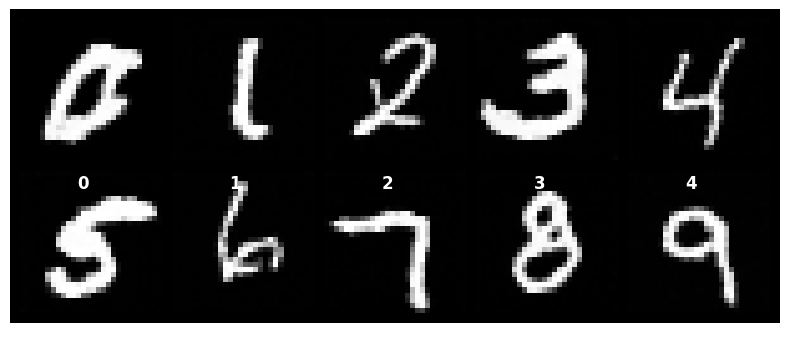

In [30]:
alpha_hats_prev = torch.cat([
    torch.ones(1, device=alpha_hats.device, dtype=alpha_hats.dtype),
    alpha_hats[:-1]
])
posterior_var = betas * (1.0 - alpha_hats_prev) / (1.0 - alpha_hats)
posterior_var = torch.cat([posterior_var, betas[-1:]])

digits   = list(range(10))
samples  = []

for d in digits:
    img = sample_cond_ddpm(model, target_label=d, n_samples=1)
    samples.append(img)

samples = torch.cat(samples, dim=0)

grid = make_grid(samples, nrow=5, padding=2, normalize=True)

plt.figure(figsize=(8, 4))
plt.imshow(grid.permute(1, 2, 0).cpu(), cmap="gray")
plt.axis("off")

for idx, d in enumerate(digits):
    row, col = divmod(idx, 5)
    x_txt = col * (28 + 2) + 14
    y_txt = row * (28 + 2) + 32
    plt.text(x_txt, y_txt, str(d), ha="center", va="top",
             fontsize=12, color="white", weight="bold")

plt.tight_layout()
plt.show()


---
# 🧪 Task 3: Text-Guided Image Generation using CLIP + Diffusion

### 🔎 Step 1: Load a Pretrained CLIP Model

Use OpenAI’s CLIP model to obtain a text embedding from a given prompt.

🔍 Your task:
- Find and install the CLIP library.
- Load a pretrained CLIP model of your choice.
- Write a function to get normalized CLIP text embeddings from a prompt.

💡 Hint: Look into the `clip` module and `clip.tokenize`, `clip.load`, and `clip.encode_text`.


In [8]:
!pip install --quiet git+https://github.com/openai/CLIP.git


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.3 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcugraph-cu12 24.12.0 requires pylibraft-cu12==24.12.*, but yo

In [44]:
import clip
import torch
guidance_scale = 2.0
device = "cuda" if torch.cuda.is_available() else "cpu"
sqrt_alpha_t_inv   = 1.0 / torch.sqrt(alphas)
beta_over_sqrt_ahat= betas / torch.sqrt(1 - alpha_hats)

diffusion_model = UNetMNIST().to(device) 
state = torch.load("/kaggle/working/task1.pt", map_location=device)
diffusion_model.load_state_dict(state)
diffusion_model.eval()

clip_model, _ = clip.load("ViT-B/32", device=device)
clip_model.eval()


@torch.no_grad()
def clip_text_embed(prompt: str,
                    model=clip_model,
                    device=device) -> torch.Tensor:
    tokens    = clip.tokenize(prompt).to(device)
    text_feats = model.encode_text(tokens)
    text_feats = text_feats.float()
    text_feats /= text_feats.norm(dim=-1, keepdim=True)
    return text_feats


/tmp/ipykernel_120/1182963616.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load("/kaggle/working/task1.pt", map_location=device)


### 🖼️ Step 2: Implement CLIP-Guided Loss

Create a function that:
- Resizes the generated image to 224x224.
- Converts it to 3 channels.
- Passes it through CLIP’s image encoder.
- Calculates the **cosine similarity** with the given text embedding.
- Returns the CLIP loss: `1 - cosine_similarity`.

📌 This loss will be used to guide your diffusion sampling.


In [45]:
CLIP_MEAN = torch.tensor([0.5, 0.5 , 0.5])
CLIP_STD  = torch.tensor([0.5, 0.5, 0.5])

def clip_guidance_loss(x,
                       text_emb,
                       clip_model,
                       device=None):
    """
    Returns a *minimisation* loss = 1 − cosine_sim( img , prompt ).

    x          : batch from your diffusion sampler (B,C,H,W) in [0,1].
                 C can be 1 or 3, any height/width.
    text_emb   : CLIP text embeddings from Step 1, unit-length, (B,512).
    clip_model : the `clip.load(..)[0]` model
    """
    if device is None:
        device = next(clip_model.parameters()).device
    B = x.size(0)
    x = x.to(device, dtype=torch.float32)

    if x.size(1) == 1:
        x = x.repeat(1, 3, 1, 1)

    x = F.interpolate(x, size=(224, 224), mode="bilinear", align_corners=False)

    mean = CLIP_MEAN.view(1, 3, 1, 1).to(device)
    std  = CLIP_STD .view(1, 3, 1, 1).to(device)
    x = (x - mean) / std

    img_feats = clip_model.encode_image(x).float()
    img_feats = img_feats / img_feats.norm(dim=-1, keepdim=True)

    cos_sim = (img_feats * text_emb.to(device)).sum(dim=-1)
    return 1.0 - cos_sim

### 🔁 Step 3: Implement Text-Guided Sampling

You will now generate an image **guided by a text prompt** using the reverse diffusion process.

🔧 Modify the DDPM sampling loop:
- At each step, predict noise using your model from task 1.
- Add a CLIP-guided loss term.
- Backpropagate through the generated image and adjust it with the CLIP gradient.

🧠 Use your diffusion schedule (`alpha`, `alpha_hat`, `beta`) from previous tasks.


In [46]:
def text_guided_ddpm(model, text_emb, n_steps_per_t=1, lr=0.05):
    model.eval()
    B = text_emb.size(0)
    x = torch.randn(B, 1, 28, 28, device=device).requires_grad_(True)

    for t in reversed(range(T)):
        t_batch = torch.full((B,), t, device=device, dtype=torch.long)
        eps_pred = model(x, t_batch)
        mu = sqrt_alpha_t_inv[t] * (x - beta_over_sqrt_ahat[t] * eps_pred)
        for _ in range(n_steps_per_t):
            img_for_clip = mu.clamp(0,1).detach().clone().requires_grad_(True)
            clip_loss = clip_guidance_loss(img_for_clip, text_emb, clip_model).mean()
            clip_loss.backward()
            x.data = x.data - clip_lr * guidance_scale * img_for_clip.grad
            x.grad = None

        if t > 0:
            noise  = torch.randn_like(x)
            sigma  = torch.sqrt(posterior_var[t])
            x.data = mu + sigma * noise
        else:
            x.data = mu

    return x.clamp(0, 1)

### 🎯 Step 4: Generate Images from Prompts

Generate one image each for the following prompts:

- `"two"`
- `"five"`
- `"nine"`

Use your `text_guided_sample` function and visualize the results using `matplotlib`.

🎨 Title each image with the prompt used.


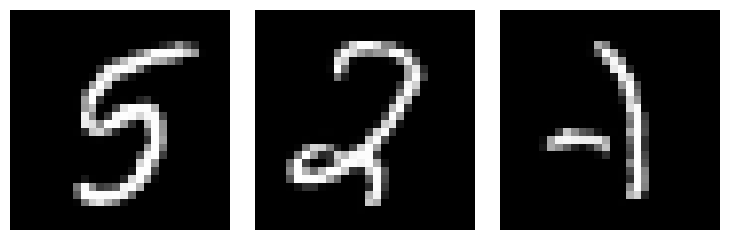

In [ ]:
prompts        = ["five", "two", "nine"]
n_steps_per_t  = 5
clip_lr        = 0.15

generated = []
for p in prompts:
    text_emb = clip_text_embed(p)
    img      = text_guided_ddpm(
                   diffusion_model,
                   text_emb,
                   n_steps_per_t=n_steps_per_t,
                   lr=clip_lr
               )
    generated.append(img)

generated = torch.cat(generated, dim=0).cpu()  

imgs = generated.squeeze(1)

fig, axs = plt.subplots(1, len(prompts), figsize=(len(prompts)*2.5, 2.5))
for ax, img, label in zip(axs, imgs, prompts):
    ax.imshow(img.detach().cpu(), cmap="gray")
    ax.axis("off")

plt.tight_layout()
plt.show()

### 🔍 Questions

1. Do the outputs look like the digits you prompted?
   Ans: after continuously running it gives the correct digits sometimes and doesnt at times, guidance strength effects it at point but doesnt at some points
3. How sensitive is the model to different wording (e.g., "number two" vs. "two")?
   Ans: CLIP tokens for “two” vs. “number two” occupy almost identical regions in embedding space, so diffusion paths overlap.
Only large semantic shifts perturb the reverse‐diffusion path noticeably.
4. What would happen if you guide the image with a totally unrelated prompt (e.g., "dog")?
    Ans: It stops making digits and tries to draw dog-like shapes instead. It will get fuzzy animal features rather than clear numbers.
